# Solving a 2nd order ODE with a feed-forward neural network using Autograd

Ordinary differential equations (ODEs) are essential for modeling physical and chemical phenomena. While other methods exist (such as the finite-difference method) are excellent at numerically solving ODEs, neural networks offer a promising alternative to numerically calculate the solution to these problems. 

In this notebook, we consider how to numerically solve an important 2nd order ODE that arises in physics and chemistry using a multi-layer perceptron neural network. 

Consider the following 2nd order ODE:

\begin{align}
\frac{d^2y(t)}{dt^2} = -k^2 y(t) 
\end{align}

The analytical solution to this ODE is $y(t) = \sin(kx)$ where $$y(0) = 0$$ $$y'(0) = k$$


References: \\
[1] J. Kitchin, example of solving 1D ODE with NN http://kitchingroup.cheme.cmu.edu/blog/2017/11/28/Solving-ODEs-with-a-neural-network-and-autograd/ \\
[2] Sine activation functions https://openreview.net/pdf?id=Sks3zF9eg \\
[3] Long short-term memory neural network (not implemented here) https://link.springer.com/chapter/10.1007/978-3-319-47054-2_10/fulltext.html \\
[4] Solving DE using neural networks https://becominghuman.ai/neural-networks-for-solving-differential-equations-fa230ac5e04c


In [2]:
# Import necessary libararies / functions
!pip install autograd

from autograd import grad, elementwise_grad
from autograd.misc.optimizers import adam
import autograd.numpy as np
import matplotlib.pyplot as plt
import numpy.random as npr
import math

# Possible activation functions
def swish(x):
    return x / (1.0 + np.exp(-x))

def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))
  
def periodic(x):
    return np.sin(x)
  
def tanh(x):
    return np.tanh(x)

As described in reference [4], we solve the ODE by minimizing an objective function.  \

\begin{align}
zeq = \frac{d^2y(t)}{dt^2} + k^2 y(t) = 0 \\ 
ic  = \frac{dy(0)}{dt} - k = 0 \\
ic2 = \frac{d^2y(0)}{dt^2} = 0 
\end{align}

\begin{align}
\Psi = zeq^2 + ic^2 + ic2^2 \\ 
\end{align}

Where $\Psi$ is minimized. First we attempt calculating the solution to this ODE using a 3-layer neural network with 100 hidden nodes. 
    

In [25]:
# For simplicity, assume k is 1
k = 1
  
t = np.linspace(0, math.pi*3).reshape((-1, 1))

def ode_func(params, inputs):
  for W, b in params:
    outputs = np.dot(inputs, W) + b          
    inputs = swish(outputs)                   # Activation function
  return outputs

def ode_func_periodic(params, inputs):
  for W, b in params:
    outputs = np.dot(inputs, W) + b          
    inputs = periodic(outputs)                # Activation function
  return outputs


# Derivatives
deriv_ode_func = elementwise_grad(ode_func, 1)
deriv_2_ode_func = elementwise_grad(deriv_ode_func, 1)

deriv_ode_func_periodic = elementwise_grad(ode_func_periodic, 1)
deriv_2_ode_func_periodic = elementwise_grad(deriv_ode_func_periodic, 1)

def setup_init_nn(scale, layer_sizes):
  rs = npr.RandomState(0)
  
  return [ (rs.randn(insize, outsize) * scale, # weight matrix
            rs.randn(outsize) * scale)         # bias vector
           for insize, outsize in zip(layer_sizes[:-1], layer_sizes[1:])]

# This function is minimized
def objective(params, step):
  zeq = deriv_2_ode_func(params, t) + k*k * ode_func(params, t)
  ic = deriv_ode_func(params, 0.0) - k
  ic2 = deriv_2_ode_func(params, 0.0)
  return np.mean(zeq**2) + ic**2 + ic2**2

# This function is minimized (periodic)
def objective_periodic(params, step):
  zeq = deriv_2_ode_func_periodic(params, t) + k*k * ode_func_periodic(params, t)
  ic = deriv_ode_func_periodic(params, 0.0) - k
  ic2 = deriv_2_ode_func_periodic(params, 0.0)
  return np.mean(zeq**2) + ic**2 + ic2**2

def callback(params, step, g):
  if step % 1000 == 0:
    print("Iteration: {0:3d} Objective: {1}".format(step, objective(params, step)))

params_swish = setup_init_nn(0.1, layer_sizes = [1, 100, 1])  
params_swish = adam(grad(objective), params_swish, step_size = 0.001, num_iters = 4000, callback = callback)

params_periodic = setup_init_nn(0.1, layer_sizes = [1, 100, 1])  
params_periodic = adam(grad(objective_periodic), params_periodic, step_size = 0.001, num_iters = 4000, callback = callback)

Iteration:   0 Objective: 0.9326984741285588
Iteration: 1000 Objective: 0.04832810713161206
Iteration: 2000 Objective: 0.029326565413063253
Iteration: 3000 Objective: 0.026587576505892135
Iteration:   0 Objective: 0.9326984741285588
Iteration: 1000 Objective: 0.5572130997130711
Iteration: 2000 Objective: 0.8146232550700137
Iteration: 3000 Objective: 0.9105179229672686


(-4, 4)

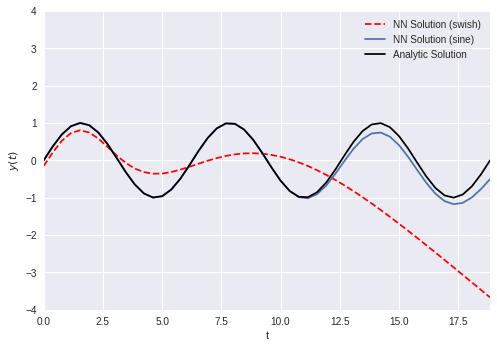

In [36]:
tfit = np.linspace(0, math.pi*6).reshape(-1, 1)
import matplotlib.pyplot as plt
plt.plot(tfit, ode_func(params_swish, tfit), 'r--', label='NN Solution (swish)')
plt.plot(tfit, ode_func_periodic(params_periodic, tfit), label='NN Solution (sine)')
plt.plot(tfit, np.sin(k*tfit), 'k', label='Analytic Solution')
plt.plot()
plt.legend()
plt.xlabel('t')
plt.ylabel('$y(t)$')
plt.xlim([0, math.pi*6])
plt.ylim([-4, 4])

The above figure shows that using a sine activation function results in a significantly better fit to data beyond the interval $[0, 3\pi]$, which the neural network was trained. Of course, this is a tad artificial because the analytic solution is sinusoidal. Additional experimention is necessary to determine how well an semi-arbitrary periodic function behaves with respect to different activation functions. 